In [1]:
import os
import pickle
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
%matplotlib tk

# Preprocess & Feature Engineering & Pickle Dump

1. The original data is obtained from the link: https://docs.quadrant.io/aws-s3-pull-data
2. The data description can be found from the link: https://docs.quadrant.io/quadrant-data-dictionary
3. For the crowd monitoring purpose, only the few attributes are required - device_id, latitude, longitutde and timestamp. The attribute 'horizontal_accuracy' is optional to enhance the performance of the model.
4. The original data is stored separately according to the date time and country. The row of the dataset represents the event of the mobile device - the location of the mobile device is detected. For each dataset, the following preprocessing step is executed in group of country:
    * The attributes 'latitude', 'longitude', 'horizontal_accuracy', and 'timestamp' is converted from string to float.
    * The attribute 'timestamp' is divided by 1000 to make it compatible to the python module datetime format.
    * The duplicated row is removed.
    * The attributes 'year', 'month', 'day', 'hour', 'minute' are extracted from the attributed 'timestamp'.
5. After the preprocessing step, the dataset is stored in a Pandas dataframe and each new preprocessed dataset is concatenated to the dataframe. The memory usage of the dataframe is keep tracked and the dataframe is saved and reset if its' size exceed 1GB.

In [ ]:
def preprocess_featureengineering(dir_file):
    df = pd.read_csv(dir_file, header=None, skip_blank_lines=True)
    df = df.iloc[:, :5]
    
    """
    columns = ['device_id', 'id_type', 'latitude', 'longitude', 'horizontal_accuracy', 
               'timestamp', 'device_os', 'device_os_version', 'country_code', 'source_id', 
               'publisher_id', 'app_id', 'background/foreground', 'geohash']
    """
    # https://www.benjaminspaulding.com/2015/09/01/long-x-lat-free-illustration-included/
    columns = ['device_id', 'latitude', 'longitude', 'horizontal_accuracy', 'timestamp']
    df.columns = columns
        
    # preprocess
    df = df[df["timestamp"] != '\\N']# remove the row without timestamp
    df.iloc[:, 1:] = df.iloc[:, 1:].astype(float) # convert str to float
    
    # keep first - mark duplicated as True except for the first occurrence
    # inplace False - return df with duplicates removed; True - replace directly
    df.drop_duplicates(keep='first', inplace=True) # drop duplicated rows within a file
    df['timestamp'] = df['timestamp'] / 1000
    
    # feature engineering
    df['year'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).year)
    df['month'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).month)
    df['day'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).day)
    df['hour'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).hour)
    df['minute'] = df['timestamp'].apply(lambda x: datetime.datetime.fromtimestamp(x).minute)
    
    return df

In [ ]:
country_target = 'country=NZ'
dir_main = '/home/chongaih/Desktop/Keppel Quadrant/quadrant/year=2019/'
dir_saved = '/home/chongaih/Desktop/Keppel Quadrant/quadrant/'

filesize = 0
count_file = 0
dir_pickle = [] # directory of stored pickle
df = pd.DataFrame({})

for month in os.listdir(dir_main):
    dir_month = dir_main + month + '/'
    
    for day in os.listdir(dir_month):
        dir_day = dir_month + day + '/'
        
        for country in os.listdir(dir_day):
            
            if country == country_target:
                dir_country = dir_day + country + '/'
                
                for file in os.listdir(dir_country):
                                        
                    dir_file = dir_country + file
                    filesize += os.stat(dir_file).st_size # in bytes
                    count_file += 1
                    
                    # concatenate all the data
                    df = pd.concat([df, preprocess_featureengineering(dir_file)], axis=0)
                    
                    if count_file % 10 == 0:
                        
                        memory_used = df.memory_usage().sum() / 1000**3 # gigabytes
                        print ('{} files completed - current file size: {:.2f}GB'.format(count_file, 
                                                                                         memory_used))
                        
                        # pickle store df and reset it to prevent running out of memory
                        if memory_used >= 1: # set threshold to be 1 gigabytes
                            
                            print ('Store and reset df')
                            
                            dir_ = dir_saved + 'quadrant_NZ{}.pkl'.format(len(dir_pickle))
                            dir_pickle.append(dir_)
                            
                            with open(dir_, 'wb') as file:
                                pickle.dump(df, file)

                            df = pd.DataFrame({})

# save the last pickle file
dir_ = dir_saved + 'quadrant_NZ{}.pkl'.format(len(dir_pickle))
dir_pickle.append(dir_)
                            
with open(dir_, 'wb') as file:
    pickle.dump(df, file)
    
# store pickle directory
with open(dir_saved + 'directory.pkl', 'wb') as file:
    pickle.dump(dir_pickle, file)
    
print ('Total file size: {:.2f}GB'.format(filesize/1000**3))

# Pickle Load & Postprocess
1. The preprocessed dataset is loaded via the stored directory. 
2. A step to note is that there are duplicated rows in the preprocessed dataset and should be removed. The reason is that the removal of duplicates in the preprocessing step only handle duplicates within a dataset file but the dataframe stores data from multiple dataset files.
3. Also, based on the attributes 'latitude', 'longitude', the outliers (with z-score more than 10) is identified and removed from the preprocessed dataset. The outliers zscore varies from dataset to dataset.

In [2]:
dir_saved = '/home/chongaih/Desktop/Keppel Quadrant/quadrant/'

# Load saved directory pickle file
with open (dir_saved + 'directory.pkl', 'rb') as file:
    dir_pickle = pickle.load(file)
    
dir_pickle

['/home/chongaih/Desktop/Keppel Quadrant/quadrant/quadrant_NZ0.pkl',
 '/home/chongaih/Desktop/Keppel Quadrant/quadrant/quadrant_NZ1.pkl',
 '/home/chongaih/Desktop/Keppel Quadrant/quadrant/quadrant_NZ2.pkl',
 '/home/chongaih/Desktop/Keppel Quadrant/quadrant/quadrant_NZ3.pkl',
 '/home/chongaih/Desktop/Keppel Quadrant/quadrant/quadrant_NZ4.pkl',
 '/home/chongaih/Desktop/Keppel Quadrant/quadrant/quadrant_NZ5.pkl']

In [ ]:
import scipy

def postprocess(df):
    # Set the outlier zscore
    outliers_zscore = 10
    
    # Sort and drop duplicated rows between files
    df = df.sort_values(['year', 'month', 'day', 'hour', 'minute'], ascending=True)
    df.drop_duplicates(keep='first', inplace=True)
    
    """
    coordinate = df[['longitude', 'latitude']].values
    mean = np.mean(coordinate, axis=0)
    std = np.std(coordinate, axis=0)

    #%matplotlib inline

    plt.figure()
    plt.scatter(coordinate[:,0], coordinate[:,1], c='r')
    plt.axhline(mean[1], linestyle='--', label='latitude - mean')
    plt.axhline(mean[1]+std[1], label='latitude - +1 std')
    plt.axhline(mean[1]-std[1], label='latitude - -1 std')
    plt.axhline(mean[1]+2*std[1], label='latitude - +2 std')
    plt.axhline(mean[1]-2*std[1], label='latitude - -2 std')
    plt.axhline(mean[1]+3*std[1], label='latitude - +3 std')
    plt.axhline(mean[1]-3*std[1], label='latitude - -3 std')
    plt.axvline(mean[0], linestyle='--', color='g', label='longitude - mean')
    plt.axvline(mean[0]+std[0], color='g', label='longitude - +1 std')
    plt.axvline(mean[0]-std[0], color='g', label='longitude - -1 std')
    plt.axvline(mean[0]+2*std[0], color='g', label='longitude - +2 std')
    plt.axvline(mean[0]-2*std[0], color='g', label='longitude - -2 std')
    plt.axvline(mean[0]+3*std[0], color='g', label='longitude - +3 std')
    plt.axvline(mean[0]-3*std[0], color='g', label='longitude - -3 std')
    plt.axvline(mean[0]+5*std[0], color='g', label='longitude - +5 std')
    plt.axvline(mean[0]-5*std[0], color='g', label='longitude - -5 std')
    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()
    """
    
    # Remove outlier whose longitude or latitude zscore is larger than the set threshold
    outliers_longitude = np.abs(scipy.stats.zscore(df['longitude'].values)) <= outliers_zscore
    outliers_latitude = np.abs(scipy.stats.zscore(df['latitude'].values)) <= outliers_zscore
    df = df.loc[np.logical_and(outliers_longitude, outliers_latitude)]
    
    return df

In [4]:
# Indicate the file to be loaded
idx_fileloaded = -1

# Load saved preprocess dataframe
with open(dir_pickle[idx_fileloaded], 'rb') as file:
    df = pickle.load(file)

# Post process
df = postprocess(df)
df.head()

,device_id,latitude,longitude,horizontal_accuracy,timestamp,year,month,day,hour,minute
1557,eaab1f42-d1bf-4bda-a77a-8e24704d2fc5,-36.877770,174.80875,6.0,1.546301e+09,2019,1,1,8,0
2709,93ee1bbc-f0f0-407d-a4eb-8970cfecc186,-40.219353,175.55768,20.0,1.546301e+09,2019,1,1,8,0
2752,93ee1bbc-f0f0-407d-a4eb-8970cfecc186,-40.219353,175.55768,10.0,1.546301e+09,2019,1,1,8,0
5843,e699af47-ff5a-4a98-a258-9a0b72941025,-43.604090,172.36542,6.0,1.546301e+09,2019,1,1,8,0
6626,f9a13d6e-9a37-41f2-abe8-bac682074148,-36.850483,174.61684,11.0,1.546301e+09,2019,1,1,8,0


# Objective & Methodology

### Objective
In the crowd monitoring project, the location data of the mobile device is used to detect the occupancy rate of the certain location in building. With the occupancy rate revealed, the operation of the ACMV system can be optimized to save energy and money. For instance. the ACMV system should be controlled such that the fan can stop operating for a certain duration with lower occupancy rate and vice versa. Since there is a lag in temperature change with response to the occupancy rate, a better control strategy can be designed with the occupancy rate. The time interval to update the occupancy rate is dependent on how the rate affects the temperature change and how fast the ACMV system cools down the affected area. 

### Methodology
With the dataset, the location (longitude (x) and latitude (y)) of the mobile device is known. To extract good information and for visualizaton, a density map is generated from the location data. The density map is normally used in the crowd counting using a single image - 1) an image with labelled human heads is transformed into density map using gaussian convolution kernel in which the location with heads will display a much higher value than those without heads, 2) a convolution neural network is trained to transfrom the image (input) to the density map (target), 3) the number of people can be counted by summing the density map. The interested reader can refer to the link: http://cinslab.com/wp-content/uploads/2019/03/2019_3_7_1.pdf. In the project, the method of generating density map is modified and adopted to reflect the occupancy rate.

The time interval to update the occupancy rate/ density map is set to be 30 minutes and it should be fine tuned as mentioned in the objective. To generate the density map, the following steps are performed:

1. From the dataset, the events (detection of the mobile device) within the time interval is identified. Since there might be multiple events occured within the time interval for the same mobile device, only the most-up-to-date event is used. A Pandas dataframe is created to store the events and for each time interval, the location of the mobile device is updated if the device exists in the dataframe or else it is added. It is noticed from the dataset that the location of some mobile devices is not updated, thus, the data is considered out-dated and removed if it is not updated for 60 minutes.

2. The location data of the mobile device is sparse and connections should be created. As such, the location data is first transformed into an image-alike array. The steps are as follows:
    * From the dataframe storing the all the events, the maximum and minimum longitude and latitude are identified. To generate the image-alike array, the number of pixel is selected to be 128 and step increment in longitude and latitude are found. The coordinate of each pixel/ grid crossing is marked with accordingly and incrementally wiht the step increment - (longitude, latitude). The coordinate of the pixel remains the same across all the time interval.
    * With the grid coordinates, the nearest pixels to all the mobile devices (events identified in the current time interval) are identified.
    * For each pixel, the number of mobile devices is stored (each grid crossing might have several devices being nearest to it)
    * The generated image-alike array contains the number of mobile devices in each pixel.

3. In the original crowd counting, each pixel is maximum 1 which implies that there is a head. However, the number can be much higher than 1 in this project. Thus, a modification is made by transforming the number of mobile devices to attention in each pixel. The rational is that more attention should be paid to the pixel (location of the building) with higher number of device (occupancy rate), however, the attention is saturated as the number of device increases. An image-attention transform function is designed and a multiplier is added to adjust the rate of attention. 

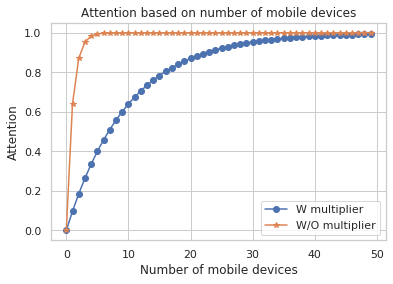

4. With the attention image, the density map is generated based on the geometry-adaptive gaussian convolution kernel. For gaussian convolution kernel, the sigma (standard deviation) is first determined to estimate how the current pixel is affecting the others. In the project, it can be imagined as how the temperature nearby the location is affected by the occupancy rate at the location. The sigma is found using the following methods:
    * Build a KDTree to identify 10 nearest neigbor (location with mobile device) and the distance to it.
    * The sigma is equal to the average distance multiplied with a ratio which is a hyperparameter to be fine tuned.
    * P/S: KDTree is used instead of KNN as it is faster (O(NlogN) vs O(N*N)). Interested reader can refer to the following links for more information: 1) https://www.analyticsvidhya.com/blog/2019/02/building-crowd-counting-model-python/, 2) https://www.analyticsvidhya.com/blog/2017/11/information-retrieval-using-kdtree/, 3) https://www.youtube.com/watch?v=UPAnUE_g5SQ

5. With the sigma, the density map is computed by checking how each pixel affecting the others using the gaussian convolution kernel. Note that only the pixels with number of mobile device/ attention are considered in computing the density map.

### Hyperparameter
1. time interval to update the density map
2. time interval to remove the out dated data
3. number of pixels for the image-alike array
4. multiplier in the image-attention transform function
5. leaf size, number of neighbors of KDTree
6. ratio of geometry-adaptive gaussian kernel

# Function - Generate Image for Density Map

In [5]:
import numpy as np

num_pixel = 128

def generate_image(max_longitude, min_longitude, max_latitude, min_latitude, df_update):

    # Determine the number of pixel and step size of longitude and latitude
    step_longitude = (max_longitude - min_longitude) / num_pixel
    step_latitude = (max_latitude - min_latitude) / num_pixel

    # Determine the grid coordinates 
    x = np.arange(min_longitude, max_longitude, step_longitude)
    y = np.arange(min_latitude, max_latitude, step_latitude)

    # Create the grid - grid's shape = [num_pixel**2, 2]
    # repeat: [1, 2, 3] --> [1, 1, 2, 2, 3, 3]
    # tile: [1, 2, 3] --> [1, 2, 3, 1, 2, 3]
    # grid: [[x0, y0], [x0, y1], [x0, y2], ... [x1, y0], [x1, y1], ...]
    # https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-111.php
    grid = np.transpose([np.repeat(x, len(y)), np.tile(y, len(x))])

    # Compute the euclidean distance
    # Select the closest grid coordinates for each mobile device
    grid_closest = np.argmin(np.sqrt((grid[:, 0:1] - df_update['longitude'].values)**2 +
                            (grid[:, 1:2] - df_update['latitude'].values)**2), axis=0)

    # Create the 2d-array (image-like) for density map - shape = [num_pixel, num_pixel]
    # The value contained in each pixel is the number of mobile device
    image = np.zeros((num_pixel, num_pixel))
    rows = grid_closest % num_pixel
    columns = grid_closest // num_pixel
    for i, (row, column) in enumerate(zip(rows, columns)):
        image[row, column] += 1

    # Grid y coordinate minimum starts from the bottom left
    # Array row coordinate minimum starts from the top left
    image = np.flipud(image) 

    """
    # Plot the mobile device crowd monitoring image
    plt.figure()
    plt.imshow(255-image) # for image - 255 represents white
    plt.xticks(np.arange(0, num_pixel, 10), ['{:.1f}'.format(x_) for x_ in x[::10]], rotation=0)
    plt.yticks(np.arange(0, num_pixel, 10), ['{:.1f}'.format(y_) for y_ in y[::-10]], rotation=0) # y is flipped
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Mobile device crowd monitoring in New Zealand')
    plt.suptitle('{} to {}'.format(s1, s2))
    plt.show()
    """

    return image, x, y

# Function - Transform Image from Number of Devices to Importance

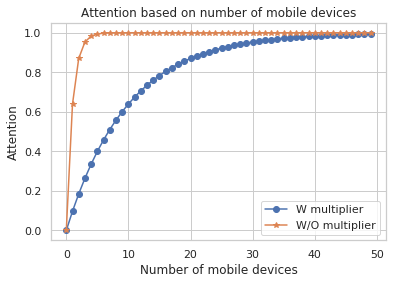

In [5]:
# Set the degree of importance
multiplier = 0.1

num_device = np.linspace(0, 50, 50)

%matplotlib inline
plt.figure()
plt.plot(1 - np.exp(-multiplier * num_device), "o-", label='W multiplier')
plt.plot(1 - np.exp(-num_device), "*-", label='W/O multiplier')
plt.legend()
plt.xlabel("Number of mobile devices")
plt.ylabel("Attention")
plt.title("Attention based on number of mobile devices")
plt.show()     

In [6]:
# Set the degree of importance
multiplier = 0.1

def transform_image(image):
    return 1 - np.exp(-multiplier * image)

# Function - Generate Density Map

In [7]:
import scipy
from sklearn.neighbors import KDTree

# Set the parameter for KDtree and gaussian filter
ratio = 1
num_neighbor = 10
leaf_size = 40

def gaussian_filter_density(image):
    
    shape = image.shape
    count_device = np.count_nonzero(image)
    
    # Initialize the density map and return density map if there is no mobile device
    density_map = np.zeros(shape)
    if count_device == 0:
        return density_map
    
    # Only use the non-zero points/ points with mobile device
    # list(zip(array1, array2)) --> create pairwise list
    pts = np.array(list(zip(np.nonzero(image)[0], np.nonzero(image)[1])))
    
    # Build KDTree and query for the nearest k distances
    # KDTree (O(dlog_2(n))) is faster in checking the nearest neigbour than KNN (O(nd))
    tree = KDTree(pts, leaf_size=leaf_size)
    distances, locations = tree.query(pts, k=num_neighbor)

    for i, pt in enumerate(pts):
        
        # Based on the paper, the sigma of gaussian kernel is the average distance of K-nearest neigbours
        # The average distance is multiplied with a ratio (to be fine tuned)
        if count_device > 1:
            sigma = np.average(distances[i])*ratio
        else:
            sigma = np.average(np.array(shape))/2./2. # If there is only a mobile device
        
        # For each coordinate, check how it is affected by those points with mobile devices
        density_map += scipy.ndimage.filters.gaussian_filter(image, sigma, mode='constant')
        
    return density_map

# Result

### Density Map of Each Time Interval

In [8]:
# Set directory for images saved
dir_imagesaved = '/home/chongaih/Desktop/Keppel Quadrant/'

# Set the time interval for update
timedelta_interval = datetime.timedelta(minutes=30).total_seconds() # minutes
timedelta_outdated = datetime.timedelta(minutes=60).total_seconds() # minutes

# Set number of days for display
days = 1

# Initialization
start = df['timestamp'].values[0]
end = start + datetime.timedelta(days=days).total_seconds() #df['timestamp'].values[-1]
fig = plt.figure(figsize=(20, 10)) # Same figure will be updated

# Set the x and y limit of coordinates to be used in attention image
# Maintained across different time interval
max_longitude = np.max(df['longitude']) + 0.5
min_longitude = np.min(df['longitude']) - 0.5
max_latitude = np.max(df['latitude']) + 0.5
min_latitude = np.min(df['latitude']) - 0.5

current_start = start
df_update = pd.DataFrame({})
devicecount_timeflow = []

while current_start < end:
    
    # Select the events within the time interval
    current_end = current_start + timedelta_interval
    idx = (df['timestamp'] >= current_start) & (df['timestamp'] < current_end)
    df_current = df.loc[idx][['device_id', 'latitude', 'longitude', 'timestamp']]
    
    # Reset index for finding the correct index of the most up to date event 
    df_current.reset_index(drop=True, inplace=True) # index = 0, 1, 2, ...
    
    # For the multiple events of the same device captured within the time interval
    # Select the most up to date event by finding the index of corresponding rows
    df_current = df_current.loc[df_current.groupby(['device_id'])['timestamp'].idxmax()]
    
    # Initializate the dataframe for update
    if df_update.empty:
        df_update = df_current
        
    else:
        
        # Set device id as dataframe index for fast updating
        df_current.set_index(['device_id'], drop=True, inplace=True) # index = device1, device2, ...
        df_update.set_index(['device_id'], drop=True, inplace=True) # index = device1, device2, ...
        
        # update any existing value - inplace update
        df_update.update(df_current)
        
        # Reset the index for concatenation (keep device_id) and drop duplicates
        # Without resetting the index, the device_id is not considered in identifying th duplicates
        # np.sum(df_current.duplicated(keep='first'))
        df_current.reset_index(drop=False, inplace=True) # index = 0, 1, 2, ...
        df_update.reset_index(drop=False, inplace=True) # index = 0, 1, 2, ...
        
        # concatenate and drop dupliactes
        df_update = pd.concat([df_update, df_current], axis=0)
        df_update.drop_duplicates(keep='first', inplace=True)
    
    # Remove outdated events
    df_update = df_update.loc[current_end - df_update['timestamp'] < timedelta_outdated]
    
    # Generate image for density map
    image, x, y = generate_image(max_longitude, min_longitude, max_latitude, min_latitude, df_update)
    
    # Transform number of mobile device detected to importance and generate density map
    density_map = gaussian_filter_density(transform_image(image))
    
    # Visualization
    # Figure name
    s1 = datetime.datetime.strftime(datetime.datetime.fromtimestamp(current_start), format='%Y-%m-%d %H-%M-%S')
    s2 = datetime.datetime.strftime(datetime.datetime.fromtimestamp(current_end), format='%Y-%m-%d %H-%M-%S')
    
    fig.clf() # clear figure
    
    fig.add_subplot(121) # add subplot since the setting is cleared in clf()
    plt.scatter(df_update['longitude'].values, df_update['latitude'].values)
    plt.title('Update of event of individual mobile device in New Zealand \n {} to {}'.format(s1, s2))
    plt.xticks(x[::20], ['{:.1f}'.format(x_) for x_ in x[::20]])
    plt.yticks(y[::-20], ['{:.1f}'.format(y_) for y_ in y[::-20]])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    fig.add_subplot(122)
    sns.heatmap(density_map)
    plt.xticks(np.arange(0, num_pixel, 20), ['{:.1f}'.format(x_) for x_ in x[::20]])
    plt.yticks(np.arange(0, num_pixel, 20), ['{:.1f}'.format(y_) for y_ in y[::-20]])
    plt.title('Density map of number of mobile device in New Zealand \n {} to {}'.format(s1, s2))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.pause(0.05)
    plt.savefig(dir_imagesaved + 'result NZ/NZ - {} to {}.png'.format(s1, s2))

    # Update for next iteration
    current_start = current_end
    
    # Store device count at each pixel/ coordinate for each time interval
    devicecount_timeflow.append(image)

    print (s1, s2, df_update.shape)

plt.show()

2019-01-01 08-00-49 2019-01-01 08-30-49 (5569, 4)
2019-01-01 08-30-49 2019-01-01 09-00-49 (9255, 4)
2019-01-01 09-00-49 2019-01-01 09-30-49 (9404, 4)
2019-01-01 09-30-49 2019-01-01 10-00-49 (9413, 4)
2019-01-01 10-00-49 2019-01-01 10-30-49 (9466, 4)
2019-01-01 10-30-49 2019-01-01 11-00-49 (9289, 4)
2019-01-01 11-00-49 2019-01-01 11-30-49 (8952, 4)
2019-01-01 11-30-49 2019-01-01 12-00-49 (8481, 4)
2019-01-01 12-00-49 2019-01-01 12-30-49 (7995, 4)
2019-01-01 12-30-49 2019-01-01 13-00-49 (7378, 4)
2019-01-01 13-00-49 2019-01-01 13-30-49 (6624, 4)
2019-01-01 13-30-49 2019-01-01 14-00-49 (6028, 4)
2019-01-01 14-00-49 2019-01-01 14-30-49 (5444, 4)
2019-01-01 14-30-49 2019-01-01 15-00-49 (5057, 4)
2019-01-01 15-00-49 2019-01-01 15-30-49 (5095, 4)
2019-01-01 15-30-49 2019-01-01 16-00-49 (5219, 4)
2019-01-01 16-00-49 2019-01-01 16-30-49 (4974, 4)
2019-01-01 16-30-49 2019-01-01 17-00-49 (4312, 4)
2019-01-01 17-00-49 2019-01-01 17-30-49 (3923, 4)
2019-01-01 17-30-49 2019-01-01 18-00-49 (3638, 4)


### Distribution of Number of Mobile Device at Each Location

In [9]:
# Find the timestamp from the start of the current interval
xticks = np.arange(0, len(devicecount_timeflow), 2) # the data is stored every half an hour
xticklabels = []
xticklabels.append(start)
for i in range(len(xticks)):
    timestamp = start + datetime.timedelta(hours=1).total_seconds()
    xticklabels.append(timestamp)

# Figure name
s1 = datetime.datetime.strftime(datetime.datetime.fromtimestamp(start), format='%Y-%m-%d %H-%M-%S')
s2 = datetime.datetime.strftime(datetime.datetime.fromtimestamp(end), format='%Y-%m-%d %H-%M-%S')

In [10]:
column = 100 # longitude

plt.figure(figsize=(20, 10))
for row in range(num_pixel): # latitude
    plt.clf()
    plt.plot(np.array(devicecount_timeflow)[:, row, column], '*-')
    plt.xticks(xticks, [datetime.datetime.strftime(datetime.datetime.fromtimestamp(timestamp), 
                                                    format='%H-%M-%S') for timestamp in xticklabels], rotation=45)
    plt.xlabel('Time')
    plt.ylabel('Number of mobile device')
    plt.title('Distribution of number of mobile device in New Zealand \n {} to {} \n @ ({:.2f}, {:.2f})'
              .format(s1, s2, x[column], y[::-1][row]))
    plt.savefig(dir_imagesaved + 'result NZ/NZ distribution - {} to {} @ ({:.2f}, {:.2f}).png'
                .format(s1, s2, x[column], y[::-1][row]))
    plt.pause(0.05)
    print ('({:.2f}, {:.2f})'.format(x[column], y[::-1][row]))
plt.show()

(174.85, -33.57)
(174.85, -33.73)
(174.85, -33.89)
(174.85, -34.05)
(174.85, -34.21)
(174.85, -34.37)
(174.85, -34.53)
(174.85, -34.69)
(174.85, -34.85)
(174.85, -35.01)
(174.85, -35.17)
(174.85, -35.33)
(174.85, -35.49)
(174.85, -35.65)
(174.85, -35.81)
(174.85, -35.97)
(174.85, -36.13)
(174.85, -36.29)
(174.85, -36.45)
(174.85, -36.61)
(174.85, -36.77)
(174.85, -36.93)
(174.85, -37.09)
(174.85, -37.25)
(174.85, -37.41)
(174.85, -37.57)
(174.85, -37.73)
(174.85, -37.89)
(174.85, -38.05)
(174.85, -38.21)
(174.85, -38.37)
(174.85, -38.53)
(174.85, -38.69)
(174.85, -38.85)
(174.85, -39.01)
(174.85, -39.17)
(174.85, -39.33)
(174.85, -39.49)
(174.85, -39.65)
(174.85, -39.81)
(174.85, -39.97)
(174.85, -40.13)
(174.85, -40.29)
(174.85, -40.45)
(174.85, -40.61)
(174.85, -40.77)
(174.85, -40.93)
(174.85, -41.09)
(174.85, -41.25)
(174.85, -41.41)
(174.85, -41.57)
(174.85, -41.73)
(174.85, -41.89)
(174.85, -42.05)
(174.85, -42.21)
(174.85, -42.37)
(174.85, -42.53)
(174.85, -42.69)
(174.85, -42.8